In [2]:
!pip install larq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 2.3 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import larq as lq

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

11490434/11490434 [==============================] - 1s 0us/step


In [5]:
# All quantized layers except the first will use the same options
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")

model = tf.keras.models.Sequential()

# In the first layer we only quantize the weights and not the input
model.add(lq.layers.QuantConv2D(32, (3, 3),
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))

model.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))

model.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Flatten())

model.add(lq.layers.QuantDense(64, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Activation("softmax"))

In [6]:
lq.models.summary(model)

+sequential stats------------------------------------------------------------------------------------------+
| Layer                  Input prec.           Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs  32-bit MACs |
|                              (bit)                        x 1       x 1    (kB)                          |
+----------------------------------------------------------------------------------------------------------+
| quant_conv2d                     -  (-1, 26, 26, 32)      288         0    0.04           0       194688 |
| max_pooling2d                    -  (-1, 13, 13, 32)        0         0       0           0            0 |
| batch_normalization              -  (-1, 13, 13, 32)        0        64    0.25           0            0 |
| quant_conv2d_1                   1  (-1, 11, 11, 64)    18432         0    2.25     2230272            0 |
| max_pooling2d_1                  -    (-1, 5, 5, 64)        0         0       0           0            0 |
| batch_normalizati

In [24]:
from tensorflow.keras.metrics import Accuracy, Precision, Recall
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, batch_size=64, epochs=6)

test_loss, test_acc = model.evaluate(test_images, test_labels)

Epoch 1/6
938/938 [==============================] - 37s 37ms/step - loss: 0.4446 - accuracy: 0.9702
Epoch 2/6
938/938 [==============================] - 35s 37ms/step - loss: 0.4329 - accuracy: 0.9748
Epoch 3/6
938/938 [==============================] - 34s 37ms/step - loss: 0.4254 - accuracy: 0.9772
Epoch 4/6
938/938 [==============================] - 34s 36ms/step - loss: 0.4245 - accuracy: 0.9774
Epoch 5/6
938/938 [==============================] - 34s 36ms/step - loss: 0.4220 - accuracy: 0.9785
Epoch 6/6
313/313 [==============================] - 4s 9ms/step - loss: 0.3864 - accuracy: 0.9796


In [32]:
print(f"Test accuracy {test_acc * 100:.2f} %")
print(f"Test loss {test_loss * 100:.2f} %")


Test accuracy 97.96 %
Test loss 38.64 %


313/313 [==============================] - 3s 9ms/step


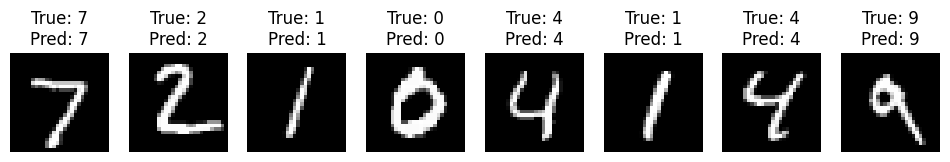

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `test_images` is your dataset of test images,
# and `test_labels` are the true labels for these images.
# Let's also assume you have a trained model named `model`.

# First, get predictions for the test dataset
predictions = model.predict(test_images)

# Convert predictions to label indexes
# If your model outputs one-hot encoded predictions, use np.argmax(predictions, axis=1)
# If your model outputs logits for classes, the same np.argmax can be applied
predicted_labels = np.argmax(predictions, axis=1)

# Now, let's plot a few test images with their predicted labels
num_images = 8  # Number of images you want to display
#Plot for the first 32 images

fig, axes = plt.subplots(1, num_images, figsize=(12, 12))
for i, ax in enumerate(axes):
    ax.imshow(test_images[i], cmap='gray')  # Assuming the images are grayscale; if not, remove `cmap='gray'`
    ax.set_title(f"True: {test_labels[i]}\nPred: {predicted_labels[i]}")
    ax.axis('off')

plt.show()
